# Regular Genomics Project **RNA Localisation**


---

**Problem definition**:

TODO


### **1.** Data Preparation

Firstly, we import several necessary packages and load in our data:

In [12]:
import pandas as pd
import numpy as np
from notes.utils import read_model_file
from models.utils import plot_line_graph, box_plot
from sklearn.model_selection import train_test_split
from keras.metrics import KLDivergence, CategoricalCrossentropy
from keras.callbacks import EarlyStopping
import datetime

In [13]:
# Initializing test/train split


colab = False  #### Set colab flag ####

if colab:
    np.random.seed(3)
    url = 'https://www.dropbox.com/s/hv4uau8q4wwg00k/final_data.csv?dl=1'
    data_org = pd.read_csv(url)
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index)
else:
    np.random.seed(3)
    data_org = pd.read_csv('~/Downloads/final_data.csv')
    test_data = data_org.sample(frac=0.1)
    train_data = data_org.drop(test_data.index) # TODO: note: we also have to preprocess the test set similary
    # TODO: colab

data_org

,ERM,KDEL,LMA,MITO,NES,NIK,NLS,NUCP,OMM,gene_id,gene_biotype,seq,struct,m6A_5UTR,m6A_CDS,m6A_3UTR
0,57.045409,35.456782,22.008215,12.355106,22.789983,24.241731,16.970436,29.348389,54.916891,ENSG00000000003,protein_coding,ACCTTGTATTAGGTATTTATTTCCACAAAAGTTTGATGCTTACAAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,1
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.914814,0.244517,ENSG00000000005,protein_coding,TGTGCACAGAAGTTATATACATATATGGGTATATCTATGTAACAAA...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
2,17.449430,34.151539,29.338431,22.237585,24.682767,43.612551,38.683963,35.678476,25.348560,ENSG00000000419,protein_coding,TACTTTATGCAAAAAAAAATATACATTTATTTATAGGTCTCAATAC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
3,3.830180,2.576734,5.737850,0.761343,2.786808,2.784356,3.382682,2.463676,2.819269,ENSG00000000457,protein_coding,TGACTTTCAAACCATTTTAATATTTCAAATATTCCAGAACAATCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,9,5
4,13.132915,8.782925,10.061390,3.012459,8.821250,6.721117,10.827253,8.005113,6.849962,ENSG00000000460,protein_coding,AACCCGCTCGGGTCCCCTTCCACACTGTGGAAGCTTTGTTCTTTCG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13805,0.000000,0.000000,0.506809,0.075893,0.050764,0.000000,0.056586,0.000000,0.000000,ENSG00000281883,protein_coding,GGGAAGAAAGGAGCCTGACTCTTATGATGGAATAACCACAAATCAG...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,2,1
13806,0.105452,0.087130,0.171187,0.016101,0.079057,0.669947,0.171672,0.000000,0.254546,ENSG00000282034,protein_coding,GTGTCGGACGGCATGACAGGCAGCAATCCTGTGTCCCCTGCCTCAT...,"[0.37599998712539673, 0.0, 0.07500000298023224...",0,66,4
13807,0.037093,0.444844,0.425368,0.254467,0.323794,1.803249,1.435483,0.249590,0.483645,ENSG00000282827,protein_coding,ATGGCGGGGACCTCCGCGCCAGGCAGCAAGAGGCGGAGCGAGCCCC...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,0
13808,0.000000,0.519421,2.119115,0.360450,0.887939,0.345021,1.274465,0.741954,0.460649,ENSG00000282936,protein_coding,CTACTGGAACGCCCCCCTCAATCTAGCCTCCCCCACATAACTCTCT...,"[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...",0,0,2


### **2** |  Initializations

We use as baseline model the [RNATracker](https://github.com/HarveyYan/RNATracker/blob/master/Models/cnn_bilstm_attention.py) model and a CNN model.


In [14]:
max_seq_len = train_data['seq'].apply(lambda x: len(x)).max()
# MODEL
model_path = "model_architectures/"

# Path where to save viz
model_architecture_path = "model_architecture_viz/simple_cnn.png"

params_dict = read_model_file('model_architectures/CNN_test.yaml', max_seq_len)
param_dataLoader_valid = params_dict['param_dataLoader_valid']
param_dataLoader_train = params_dict['param_dataLoader_train']
params_model = params_dict['params_model']
params_train = params_dict['params_train']


In [19]:
# training, only need for the model initialization to change in general
from models import CNN

VALIDATION_ACCURACY = []
VALIDATION_LOSS = []

# 80/20 split
train_split, valid_split = train_test_split(train_data, random_state=42, test_size=0.2)


# for i, (train_split, valid_split) in enumerate(folds):
model = CNN(input_size=(max_seq_len, 4),
            params_model=params_model,
            #metrics=[CategoricalCrossentropy(label_smoothing=0.01, axis=1)]
            )


history = model.fit_and_evaluate(train_data=train_split, eval_data=valid_split,
                                 params_train_dataLoader=param_dataLoader_train,
                                 params_eval_dataLoader=param_dataLoader_valid,
                                 params_train=params_train)

# results = model.evaluate(eval_data=valid_split, **param_dataLoader_valid)
# results = dict(zip(model.model.metrics_names, results))

# VALIDATION_ACCURACY.append(results['accuracy'])
# VALIDATION_LOSS.append(results['loss'])

Epoch 1/10


2023-06-26 12:37:59.606606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


311/311 [==============================] - ETA: 0s - loss: 2.2304 - accuracy: 0.1719

2023-06-26 12:39:26.725192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


311/311 [==============================] - 103s 309ms/step - loss: 2.2304 - accuracy: 0.1719 - val_loss: 2.1694 - val_accuracy: 0.1685
Epoch 2/10
311/311 [==============================] - 101s 311ms/step - loss: 2.1677 - accuracy: 0.1726 - val_loss: 2.1661 - val_accuracy: 0.1858
Epoch 3/10
311/311 [==============================] - 103s 315ms/step - loss: 2.1656 - accuracy: 0.2037 - val_loss: 2.1652 - val_accuracy: 0.2204
Epoch 4/10
311/311 [==============================] - 102s 311ms/step - loss: 2.1631 - accuracy: 0.2227 - val_loss: 2.1665 - val_accuracy: 0.2088
Epoch 5/10
311/311 [==============================] - 102s 314ms/step - loss: 2.1599 - accuracy: 0.2427 - val_loss: 2.1653 - val_accuracy: 0.2180
Epoch 6/10
311/311 [==============================] - 102s 312ms/step - loss: 2.1570 - accuracy: 0.2687 - val_loss: 2.1671 - val_accuracy: 0.2144
Epoch 7/10
311/311 [==============================] - 100s 307ms/step - loss: 2.1540 - accuracy: 0.2824 - val_loss: 2.1677 - val_accura

In [16]:
model.print_model(model_architecture_path)
import datetime
import pydot
time_date = datetime.datetime.now().date()
# time_hour = datetime.datetime.now().time()

model_output = f"model_outputs/simple_cnn_{time_date}.h5"

model.save_model(model_output)

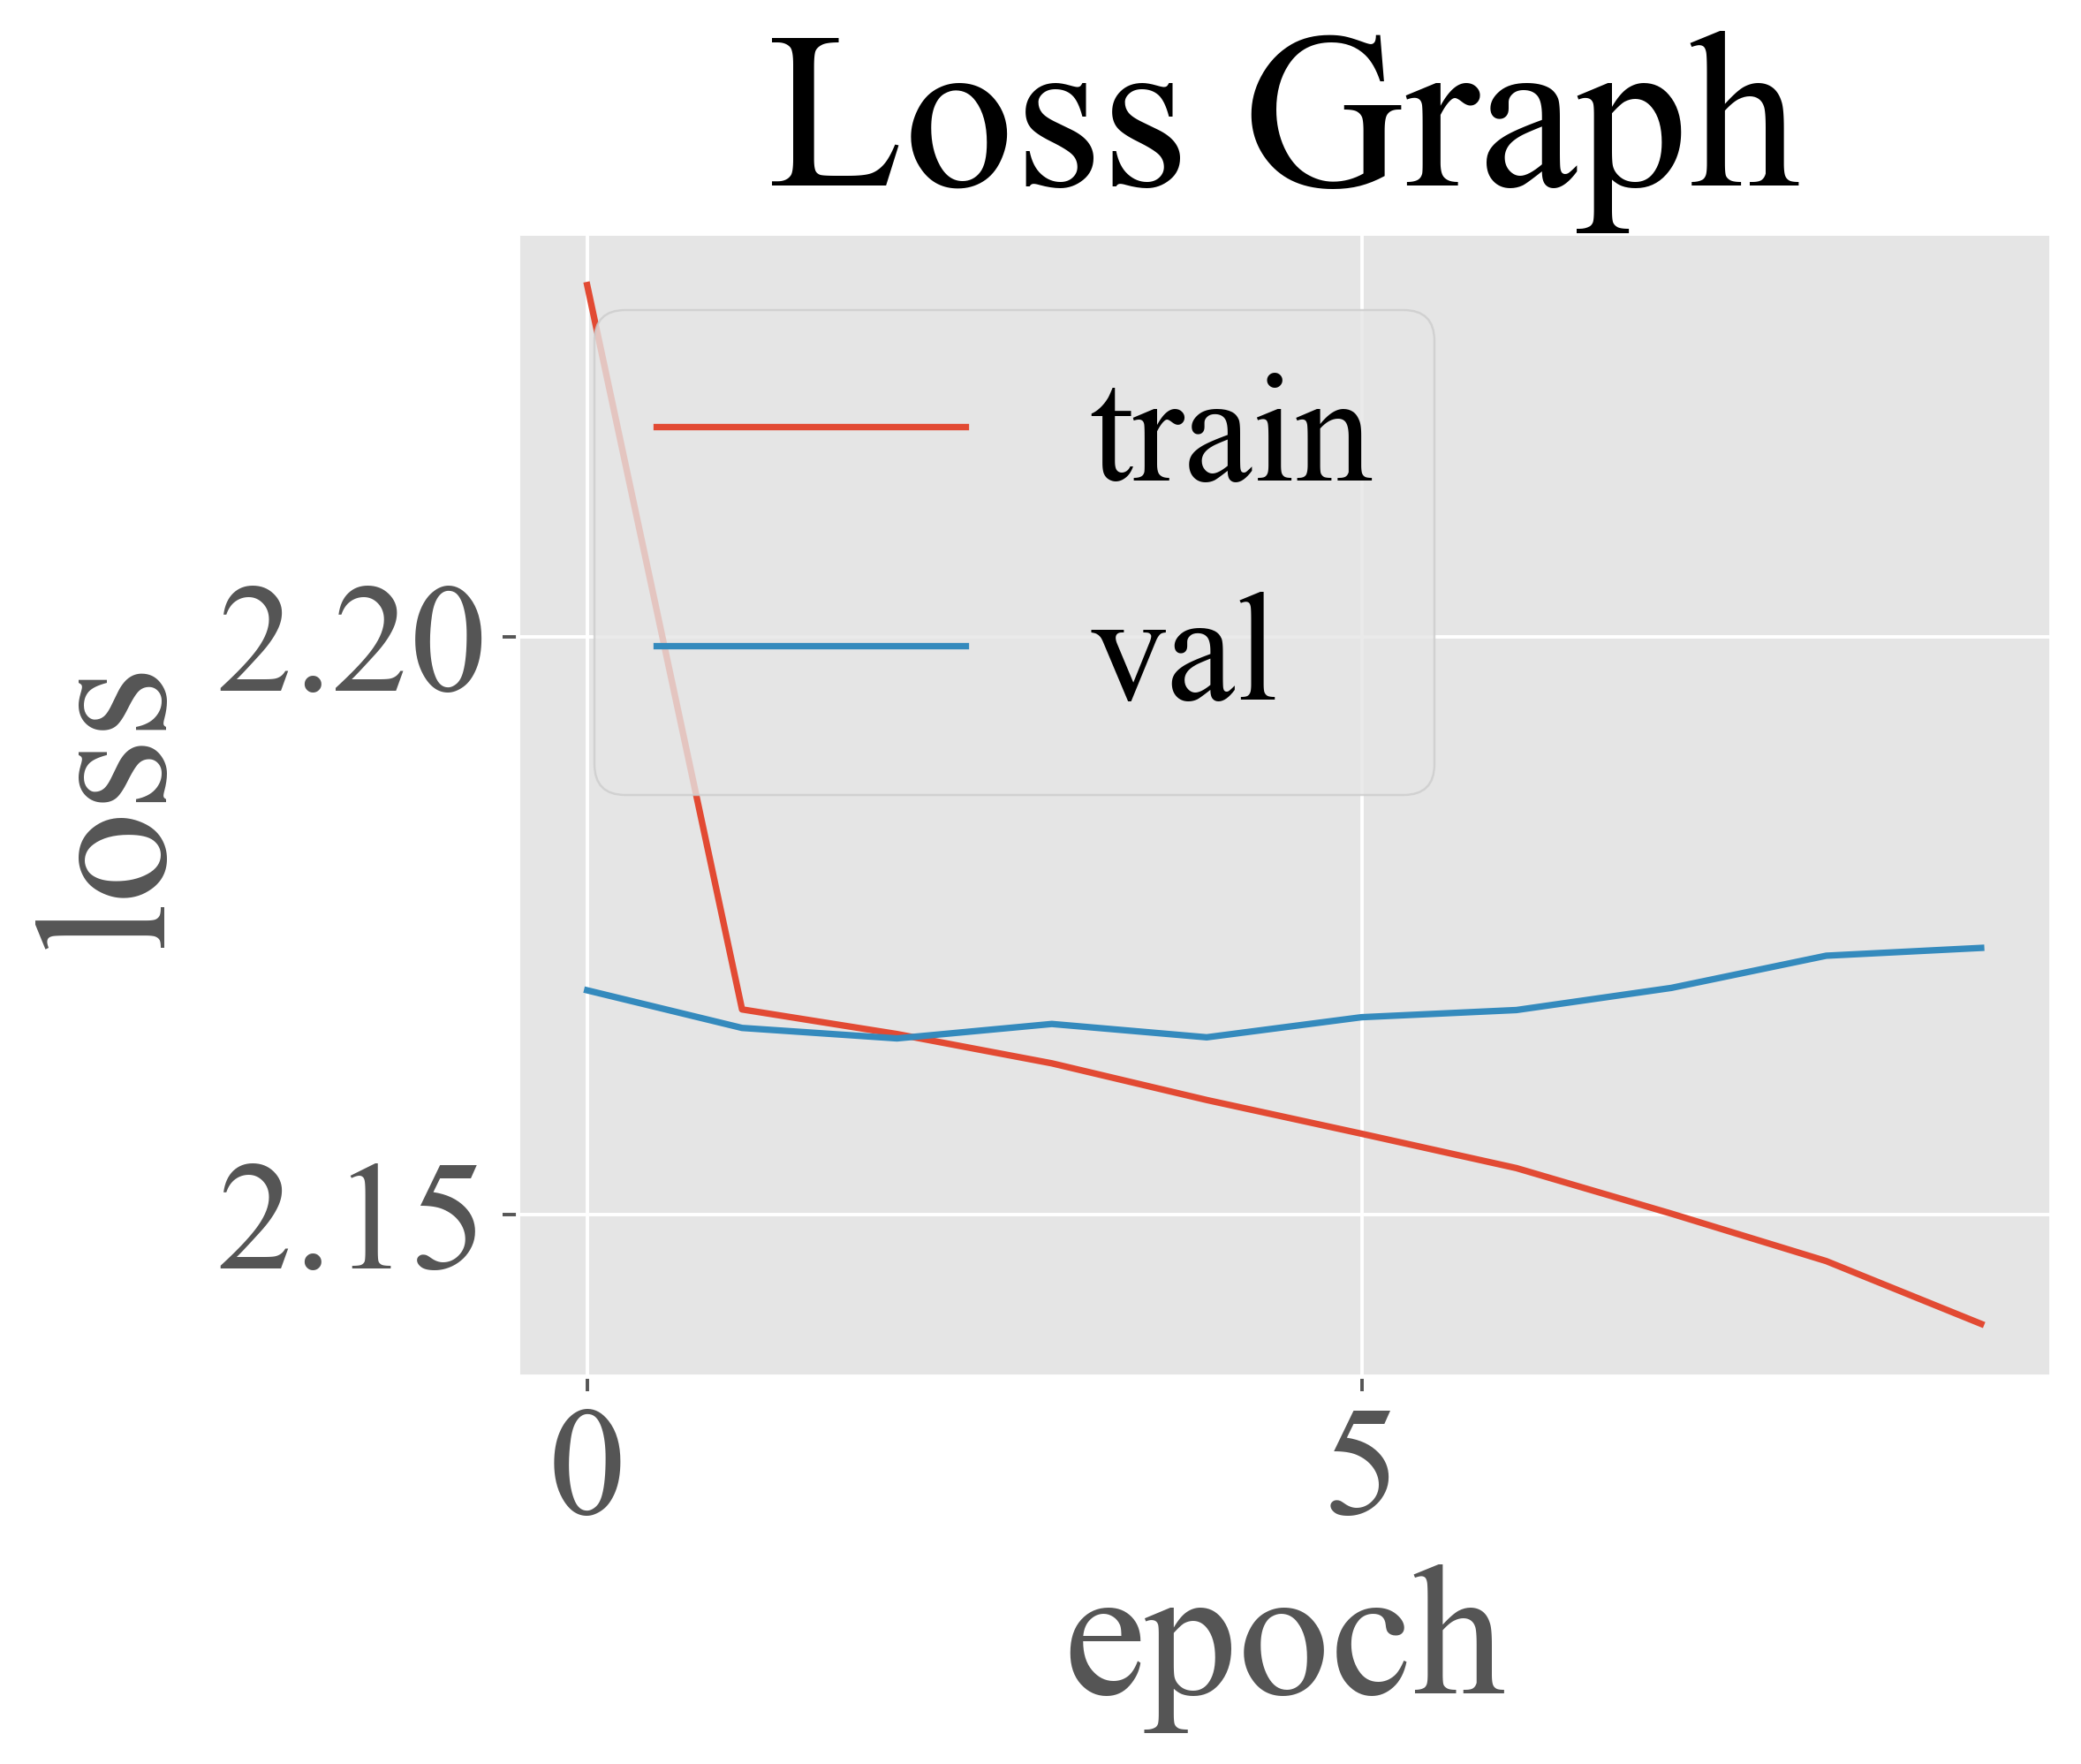

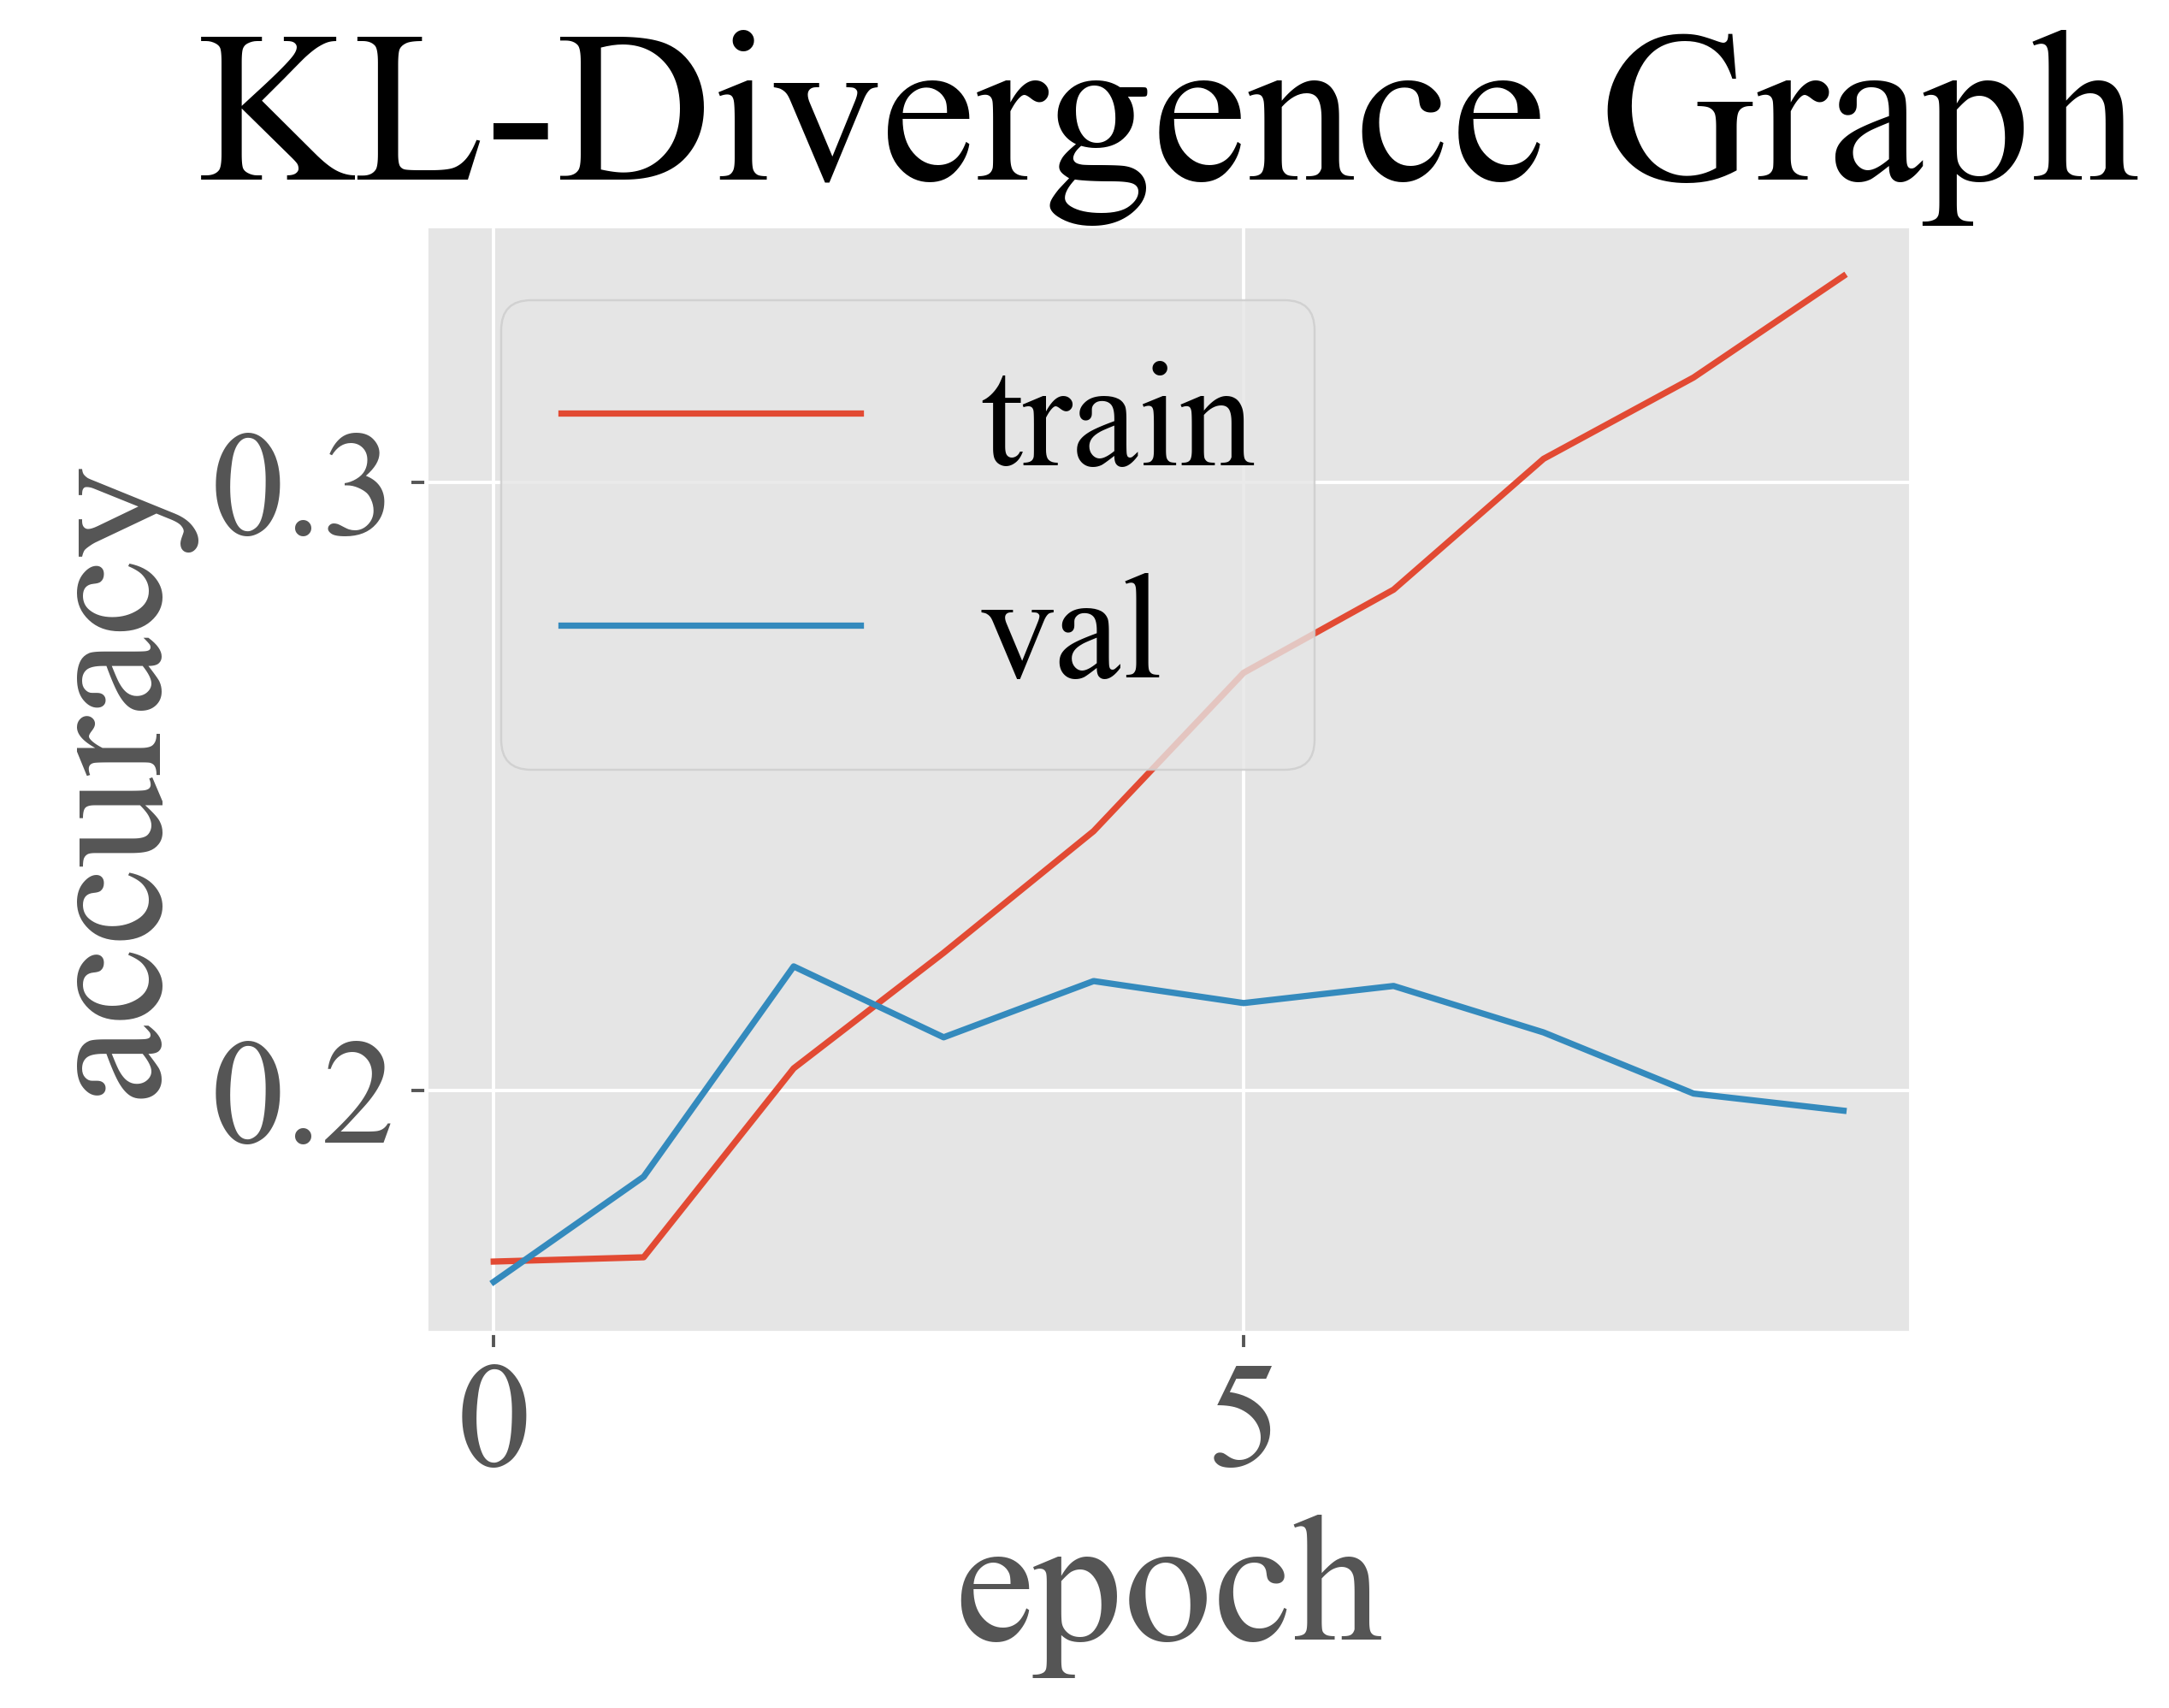

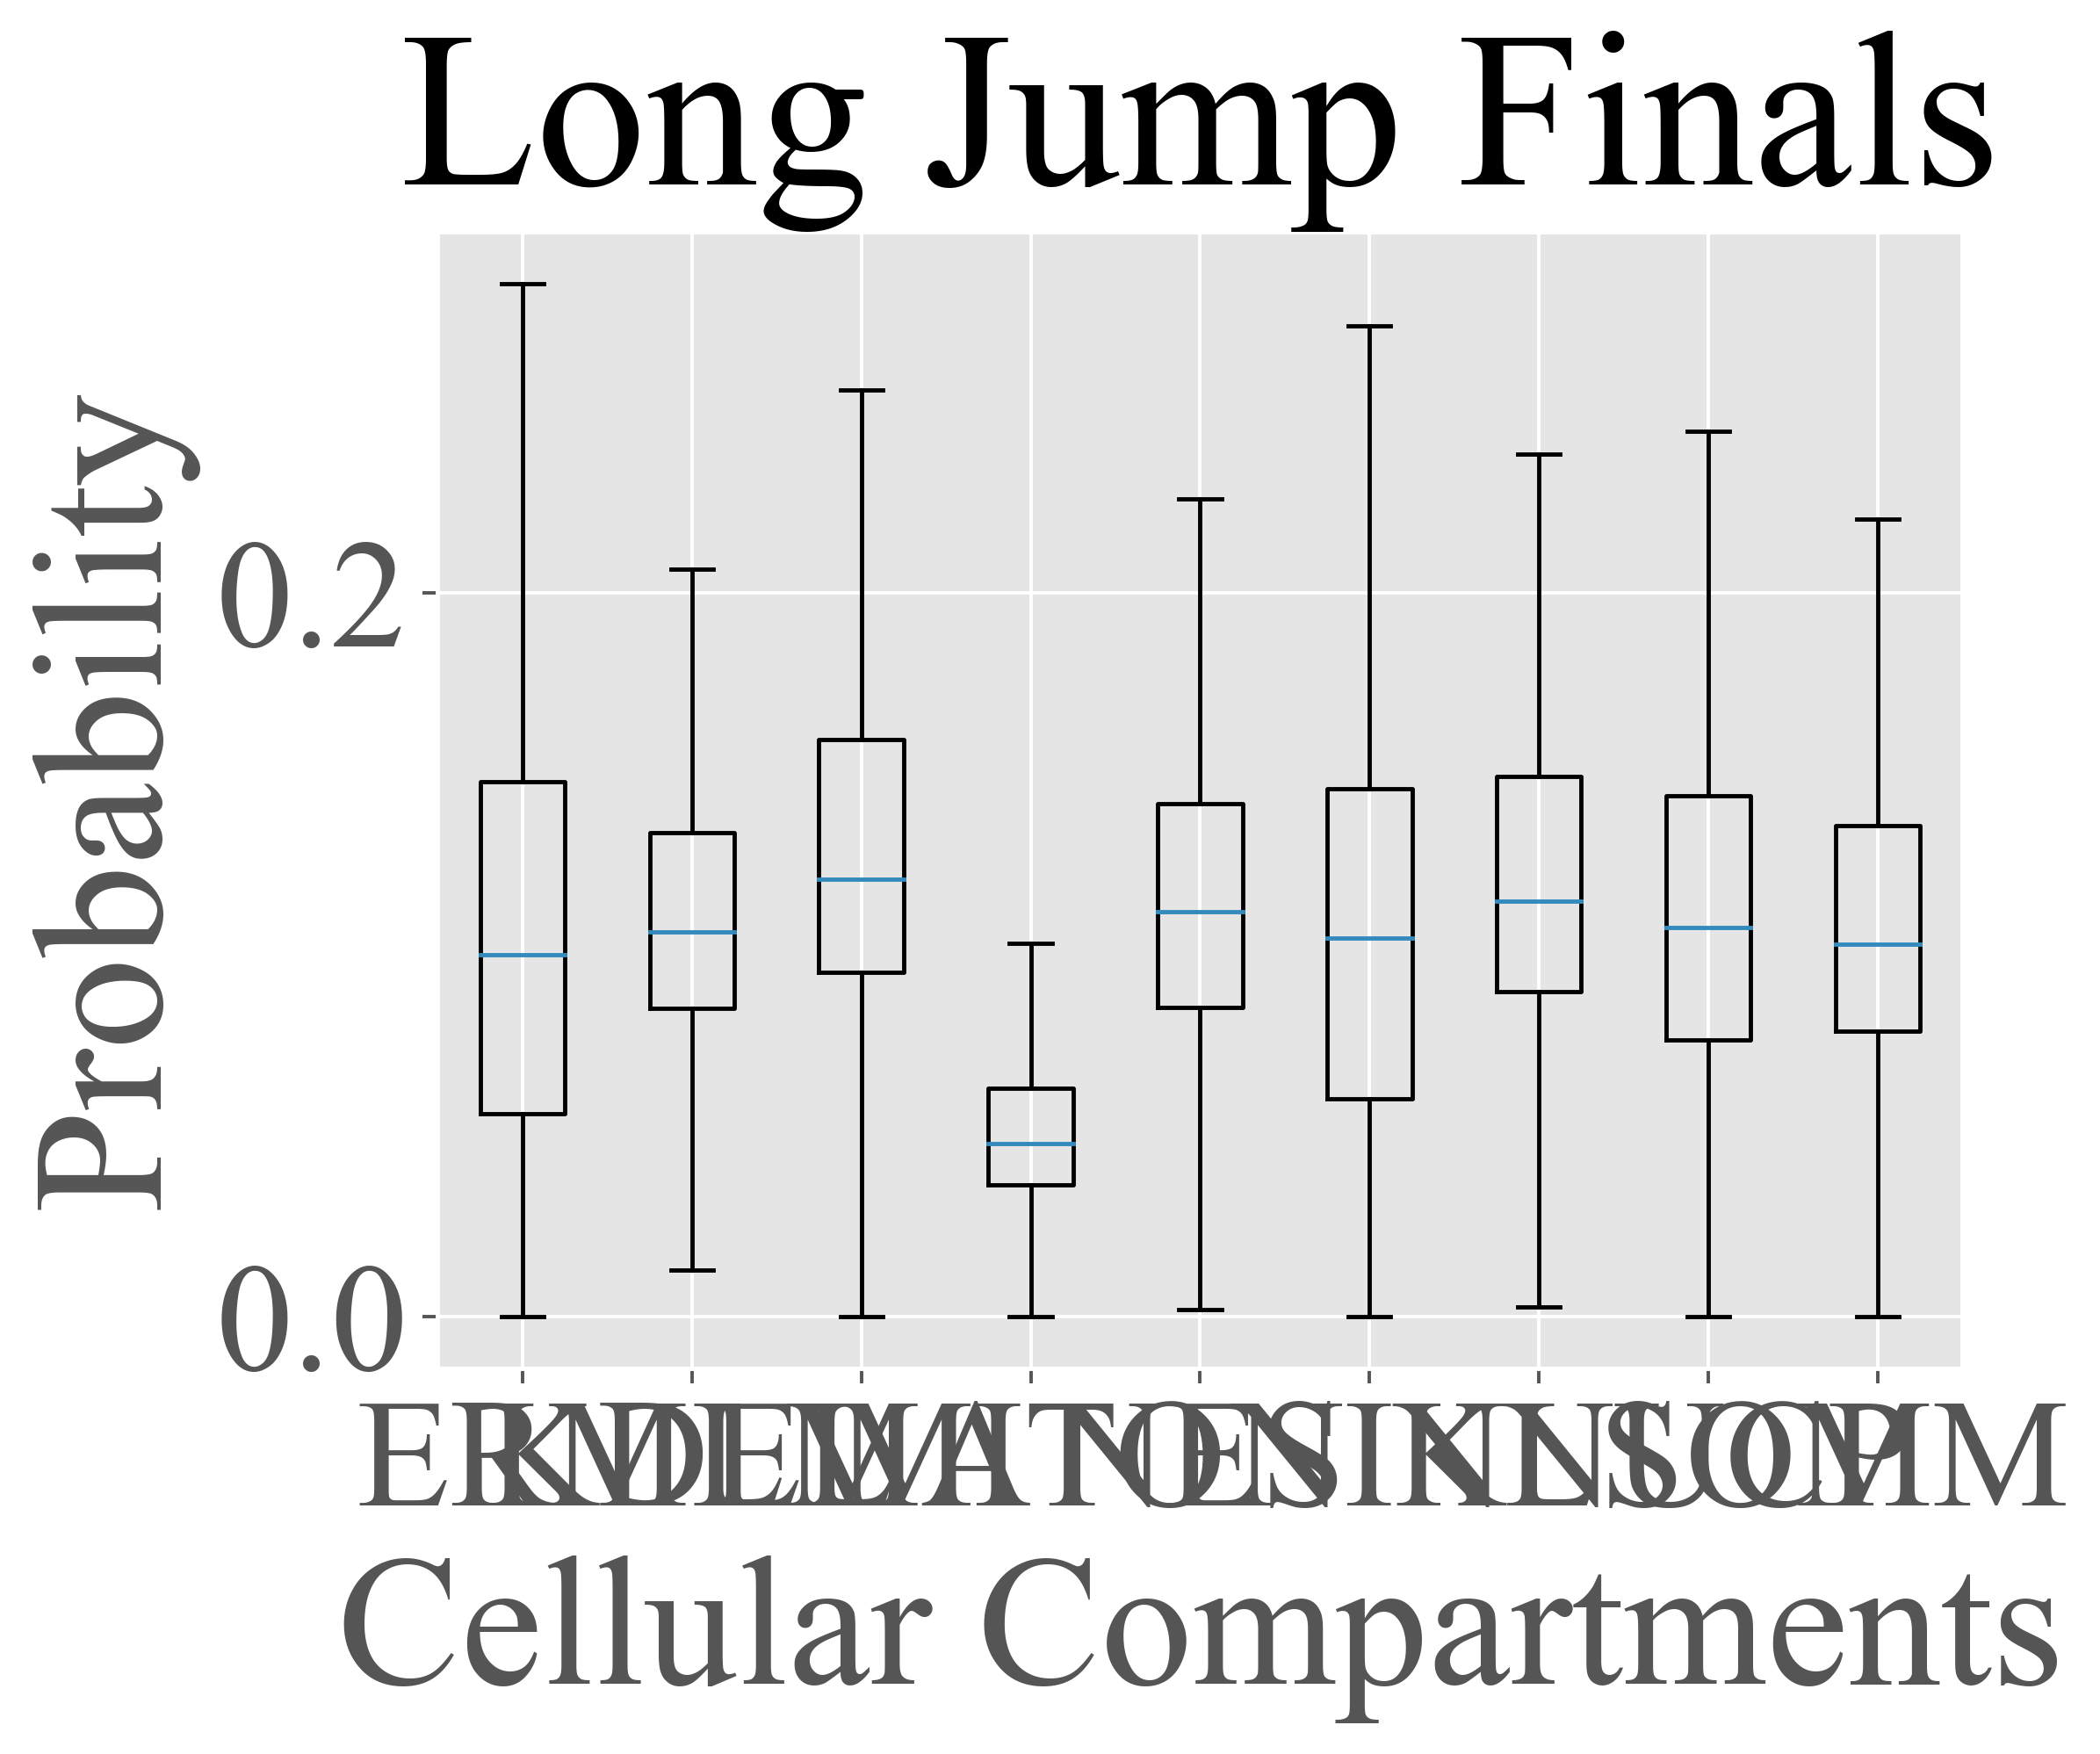

In [21]:
plt_data = [history.history['loss'], history.history['val_loss']]
plot_line_graph(plt_data, "Loss Graph", 'loss', 'epoch', ['train', 'val'])

plt_data = [history.history['accuracy'], history.history['val_accuracy']]
plot_line_graph(plt_data, "KL-Divergence Graph", 'accuracy', 'epoch', ['train', 'val'])

box_plot(train_data)

In [ ]:
test_result = model.evaluate(test_data, **param_dataLoader_valid)
result = dict(zip(model.model.metrics_names, test_result))
TEST_ACCURACY = result['accuracy']
TEST_LOSS = result['loss']

In [ ]:
VALIDATION_ACCURACY

In [ ]:
VALIDATION_LOSS